# Iris dataset

### Objectives

In this project the famous ``iris dataset`` is used to implement classification machine learning models. More specifically, we will try to predict the **specie** having information of iris and petal widths and lengths. Several cassification models are applyied and at the end the corresponding results are commented.

### Description of the data

Data obtained from Kaggle:``https://www.kaggle.com/uciml/iris``.

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report
plt.rcParams["font.family"] = "Times New Roman"

The data is imported

In [2]:
filepath = 'data/Iris.csv'
data = pd.read_csv(filepath, sep = ',')

The column **ID** is dropped since should not be considered in model fitting.

In [3]:
data = data.drop('Id', axis = 1)

In [4]:
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


The types of the features are the following:

In [5]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
(150, 5)


### Actions taken for data cleaning and feature engineering.

We first define the target and feature columns. As commented before, the target will be the flower specie.

In [6]:
target = 'Species'
data[target].value_counts(normalize = True)

Iris-setosa        0.333333
Iris-versicolor    0.333333
Iris-virginica     0.333333
Name: Species, dtype: float64

In order to apply the logistic regression, we gonna have to rescale the data. We apply the **Standard Scaler**.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# we first divide the X and y 
feature_cols = [x for x in data.columns if x != 'Species']

# Now we rescale.
scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

In [8]:
data[feature_cols].sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
2,0.111111,0.500000,0.050847,0.041667
52,0.722222,0.458333,0.661017,0.583333
106,0.166667,0.208333,0.593220,0.666667
123,0.555556,0.291667,0.661017,0.708333
60,0.194444,0.000000,0.423729,0.375000


On the other hand, we need to **label encode** the Species data.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data[target] = le.fit_transform(data[target])

y = data[target]
X = data[feature_cols]

y.value_counts()

2    50
1    50
0    50
Name: Species, dtype: int64

Now the data is prepared for model implementation. **Finally, we will explore the correlation between variables**. 

In [10]:
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

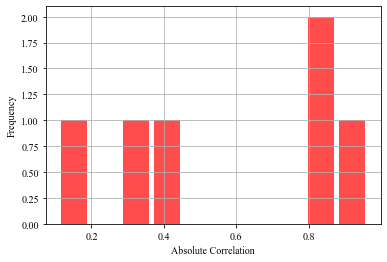

In [48]:
ax = corr_values.abs_correlation.hist(bins=10, figsize=(6, 4), 
                                      color = 'red', alpha = 0.7, 
                                      rwidth=0.85)
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False)

,feature1,feature2,correlation,abs_correlation
5,PetalLengthCm,PetalWidthCm,0.962757,0.962757
1,SepalLengthCm,PetalLengthCm,0.871754,0.871754
2,SepalLengthCm,PetalWidthCm,0.817954,0.817954
0,SepalLengthCm,SepalWidthCm,-0.109369,0.109369
4,SepalWidthCm,PetalWidthCm,-0.356544,0.356544
3,SepalWidthCm,PetalLengthCm,-0.420516,0.420516


We observe that the most correlated values are the **Petal length** and the **Petal width**. In the following pairplot we can observe it more closely.

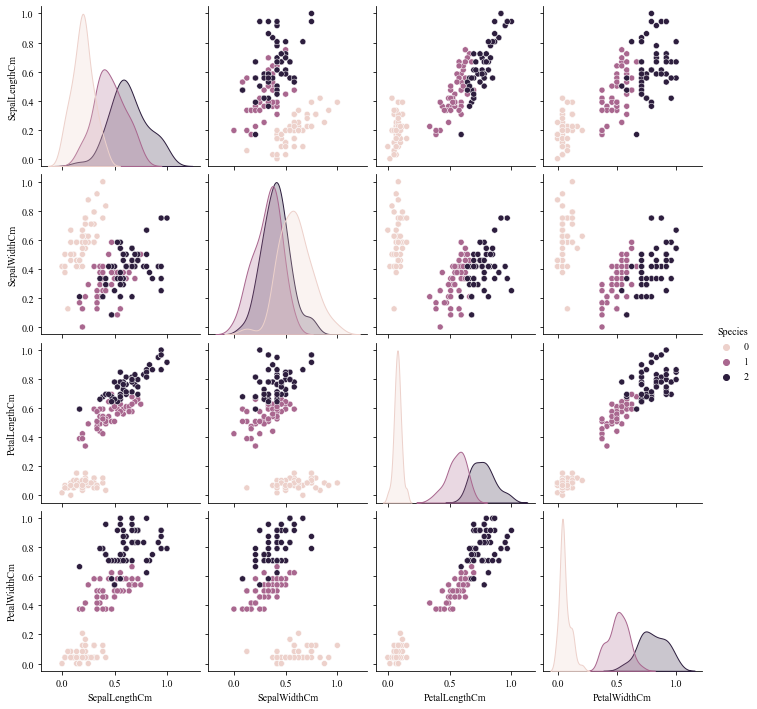

In [13]:
sns.pairplot(data, hue = 'Species')

### Training at least three different classifier models

Summary of training at least three different classifier models, preferably of different nature in explainability and predictability. For example, you can start with a simple logistic regression as a baseline, adding other models or ensemble models. Preferably, all your models use the same training and test splits, or the same cross-validation method.

### 1. Logistic regression 

In [42]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Let's split the data first:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target],
                                                   test_size=0.3, random_state=42)

# this is the standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# Now with cross validation and regularization
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

Now we compute the prediction for these models

In [15]:
y_pred = list()
y_prob = list()
cr_logR = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
    cr_lab = pd.DataFrame(classification_report(y_test, mod.predict(X_test), output_dict=True))
    cr_logR.append(cr_lab)
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

print('For LR')
print(cr_logR[0])
print('For LR with L1')
print(cr_logR[1])
print('For LR with L2')
print(cr_logR[2])

For LR
              0          1          2  accuracy  macro avg  weighted avg
precision   1.0   1.000000   0.650000  0.844444   0.883333      0.898889
recall      1.0   0.461538   1.000000  0.844444   0.820513      0.844444
f1-score    1.0   0.631579   0.787879  0.844444   0.806486      0.832288
support    19.0  13.000000  13.000000  0.844444  45.000000     45.000000
For LR with L1
              0     1     2  accuracy  macro avg  weighted avg
precision   1.0   1.0   1.0       1.0        1.0           1.0
recall      1.0   1.0   1.0       1.0        1.0           1.0
f1-score    1.0   1.0   1.0       1.0        1.0           1.0
support    19.0  13.0  13.0       1.0       45.0          45.0
For LR with L2
                   0          1     2  accuracy  macro avg  weighted avg
precision   0.904762   1.000000   1.0  0.955556   0.968254      0.959788
recall      1.000000   0.846154   1.0  0.955556   0.948718      0.955556
f1-score    0.950000   0.916667   1.0  0.955556   0.955556      

We obser that the model that performs the best is the logistic regression with **L1**.

### 2. Support Vector Machines

As recommended in the course, since we have very few data (rows)

In [16]:
data[target].value_counts()

2    50
1    50
0    50
Name: Species, dtype: int64

We have to do it only for 2 variables otherwise we cannot represent it. But of course the LSVM can be fitted with N dimensions.

In [17]:
def plot_decision_boundary(estimator, X, y):
    colors = {2:'green', 1:'red', 0:'blue'}
    estimator.fit(X, y)
    x_axis, y_axis = np.arange(0, 1, .005), np.arange(0, 1, .005)
    xx, yy = np.meshgrid(x_axis, y_axis)
    xx_ravel = xx.ravel()
    yy_ravel = yy.ravel()
    X_grid = pd.DataFrame([xx_ravel, yy_ravel]).T
    y_grid_predictions = estimator.predict(X_grid)
    y_grid_predictions = y_grid_predictions.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.contourf(xx, yy, y_grid_predictions, cmap=plt.cm.autumn_r, alpha=.3)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y.map(colors), alpha=1)
    ax.set(
        xlabel='Sepal_length',
        ylabel='Sepal_width',
        title=str(estimator))

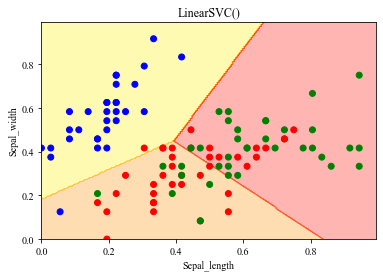

In [33]:
from sklearn.svm import LinearSVC

LSVC = LinearSVC()
LSVC.fit(X_train.iloc[:,:2], y_train)

plot_decision_boundary(LSVC, X_train.iloc[:,:2], y_train)

Now let's observe how well it has performed. In the following we represent the confusion matric and the accuracy metrics.

<AxesSubplot:>

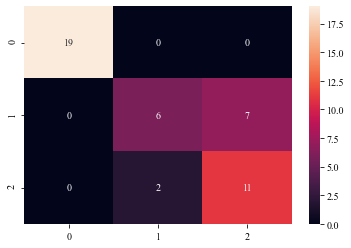

In [35]:
from sklearn.metrics import confusion_matrix

y_pred_LSVC = LSVC.predict(X_test.iloc[:, :2])
cm_LSVC = confusion_matrix(y_test, y_pred_LSVC)

sns.heatmap(cm_LSVC, annot=True)

In [38]:
cr_LSVC = pd.DataFrame(classification_report(y_test, y_pred_LSVC, output_dict=True))
cr_LSVC

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,0.750000,0.611111,0.8,0.787037,0.815432
recall,1.0,0.461538,0.846154,0.8,0.769231,0.800000
f1-score,1.0,0.571429,0.709677,0.8,0.760369,0.792320
support,19.0,13.000000,13.000000,0.8,45.000000,45.000000


I performed quite good, but the logistic regression models still can do better.

### Support Vector Mahines with Gaussian Kernel

Now let's see what happens if we consider a Gaussian Kernel.

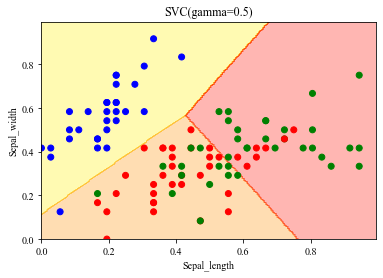

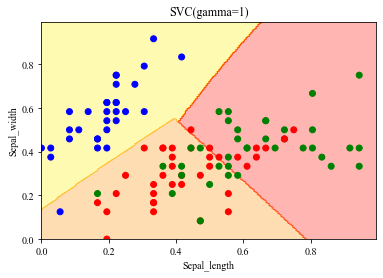

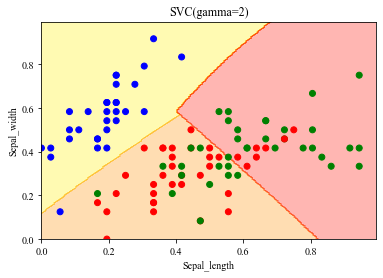

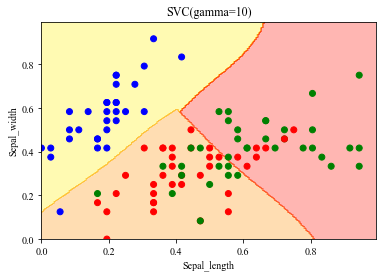

In [39]:
from sklearn.svm import SVC

gammas = [.5, 1, 2, 10]
for gamma in gammas:
    SVC_Gaussian = SVC(kernel='rbf', gamma=gamma)
    plot_decision_boundary(SVC_Gaussian, X_train.iloc[:,:2], y_train)

The decision boundaries do not change much with respect to the Linear Support Vector Classifiers (LSVC), therefore we will choose the most simple model.

### Random forest

Finally let's try what happens applying Random Forests.

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [40]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            n_jobs=-1,
                            warm_start=True)

oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees) # Aquí estem afegint el paràmetre

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df.T

n_trees,15.0,20.0,30.0,40.0,50.0,100.0,150.0,200.0,300.0,400.0
oob,0.066667,0.066667,0.07619,0.066667,0.057143,0.057143,0.066667,0.07619,0.066667,0.066667


In [41]:
cr_RF = pd.DataFrame(classification_report(y_test, RF.predict(X_test), output_dict=True))
cr_RF

,0,1,2,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
support,19.0,13.0,13.0,1.0,45.0,45.0


### Which of your classifier models you recommend

Taking into consideration the classification report I think I would choose the random forest model. Nonetheless, LSVM also work well and they cost less time to fit.

### Suggestions for next steps

Other checks could have been done. In this dataset we have small amount of data (rows), therefore, models such as the **logistic regression (LR)** and **Support Vector Machines** are the ones which work the best according to what it was introduced in lectures (as observed). Nonetheless, other models such as boosting and staking could have also been applyied.

On the other hand, here is found that the models which fit the best are **Random Forest (RF)**, but I am not sure if here we are overfitting. The **oob** error more or less remains constant for several amount of trees considered. Therefore I would recommend to work with the smallest amount of trees.